# Generating flows for the entire Sweden
1 km x 1 km with upper grid levels as 10 km x 10 km.

In [1]:
%load_ext autoreload
%autoreload 2
%cd D:\FlowsGeneration

D:\FlowsGeneration


In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import math

from tqdm import tqdm
import lib.workers as workers
import lib.sweden as sweden

In [3]:
grid_file = 'D:/FlowsGeneration/results/grids_sweden/grids_1km_density_deso_with_10km_upper_grids.shp'
grid_file_big = 'D:/FlowsGeneration/results/grids_sweden/grids_10km.shp'
zone_file = 'D:/FlowsGeneration/dbs/sweden/zones/DeSO/DeSO_2018_v2.shp'

## 0. Explore the aggregation level

In [158]:
gdf_zones = gpd.read_file(zone_file)
zone_num_agg_level = []
for level in range(2, 9):
    num_deso = pd.DataFrame(gdf_zones.loc[:, 'deso'].apply(lambda x: x[:level]), columns=['deso']).deso.nunique()
    zone_num_agg_level.append((level, num_deso))
df_agg_level = pd.DataFrame(zone_num_agg_level, columns=['level', 'num_zones'])
df_agg_level

,level,num_zones
0,2,21
1,3,89
2,4,290
3,5,741
4,6,954
5,7,1275
6,8,5984


## 1. Load data

In [111]:
# Filter out the grids which do not have the density data
grids = gpd.read_file(grid_file)
grids.head()

,zone,deso,density,upper_deso,upper_dens,upper_zone,upper_xcoo,upper_ycoo,geometry
0,18,0114A0010,15.720316,0114A0010,15.720316,1,655000.0,6595000.0,"POLYGON ((660000.000 6596000.000, 660000.000 6..."
1,8,0114A0010,15.720316,0114A0010,15.720316,1,655000.0,6595000.0,"POLYGON ((659000.000 6598000.000, 659000.000 6..."
2,20,0114A0010,15.720316,0114A0010,15.720316,1,655000.0,6595000.0,"POLYGON ((660000.000 6598000.000, 660000.000 6..."
3,19,0114A0010,15.720316,0114A0010,15.720316,1,655000.0,6595000.0,"POLYGON ((660000.000 6597000.000, 660000.000 6..."
4,1,0114A0010,15.720316,0114A0010,15.720316,1,655000.0,6595000.0,"POLYGON ((658000.000 6600000.000, 658000.000 6..."


In [112]:
# Keep those grids with density information
grids = grids.dropna(subset=['density'])

In [113]:
grids_big = gpd.read_file(grid_file_big)
grids_big.head()

,deso,density,zone,geometry
0,0114A0010,15.720316,1,"POLYGON ((650000.000 6590000.000, 650000.000 6..."
1,0114A0010,15.720316,2,"POLYGON ((650000.000 6600000.000, 650000.000 6..."
2,0114A0010,15.720316,3,"POLYGON ((660000.000 6590000.000, 660000.000 6..."
3,0114A0010,15.720316,4,"POLYGON ((660000.000 6600000.000, 660000.000 6..."
4,0114A0010,15.720316,5,"POLYGON ((670000.000 6590000.000, 670000.000 6..."


## 2. Model equation

In [114]:
def miu(density=None, r=None, f_home=None):
    return density*r**2*f_home

def para(f_max=None, T=None):
    f_min = 1/T
    return math.log(f_max / f_min)

In [115]:
T = 1000
f_max = 1
area = 1
r = 1
f_home = 1
par = para(f_max=f_max, T=T)
grids.loc[:, 'miu'] = grids.loc[:, 'density'].apply(lambda x: miu(density=x, r=r, f_home=f_home))

In [116]:
tqdm.pandas()
flows_within = grids.groupby('upper_zone').progress_apply(lambda x: workers.zone_flows(zones=x, area=area, para=par)).reset_index()

100%|██████████| 5009/5009 [01:31<00:00, 55.01it/s]


In [117]:
grids_big.loc[:, 'miu'] = grids_big.loc[:, 'density'].apply(lambda x: miu(density=x, r=10, f_home=f_home))
flows_between = workers.zone_flows(zones=grids_big, area=100, para=par)
flows_between.head()

,ozone,dzone,d_ij,v_ij
0,1,1,0.000000,inf
1,1,2,10.000000,1357.40124
2,1,3,10.000000,1357.40124
3,1,4,14.142136,678.70062
4,1,5,20.000000,339.35031


In [118]:
flows_within.replace([np.inf, -np.inf], 0, inplace=True)
flows_between.replace([np.inf, -np.inf], 0, inplace=True)

## 3. Aggregation

In [125]:
agg_level = 4

In [56]:
grids_dict = dict(zip(grids.zone, grids.deso))
grids_big_dict = dict(zip(grids_big.zone, grids_big.deso))

In [126]:
flows_within.loc[:, 'ozone_deso'] = flows_within.loc[:, 'ozone'].map(grids_dict).apply(lambda x: x[:agg_level])
flows_within.loc[:, 'dzone_deso'] = flows_within.loc[:, 'dzone'].map(grids_dict).apply(lambda x: x[:agg_level])
flows_between.loc[:, 'ozone_deso'] = flows_between.loc[:, 'ozone'].map(grids_big_dict).apply(lambda x: x[:agg_level])
flows_between.loc[:, 'dzone_deso'] = flows_between.loc[:, 'dzone'].map(grids_big_dict).apply(lambda x: x[:agg_level])

In [133]:
flows_within_deso = flows_within.groupby(['ozone_deso', 'dzone_deso'])['v_ij'].sum().reset_index()
flows_between_deso = flows_between.groupby(['ozone_deso', 'dzone_deso'])['v_ij'].sum().reset_index()
flows_deso = pd.concat([flows_within_deso, flows_between_deso]).groupby(['ozone_deso', 'dzone_deso'])['v_ij'].sum().reset_index()
flows_deso.head()

,ozone_deso,dzone_deso,v_ij
0,0114,0114,6.043523e+06
1,0114,0115,1.142625e+05
2,0114,0117,2.958039e+03
3,0114,0120,1.065879e+04
4,0114,0123,8.920203e+05


## 4. Comaprison

In [129]:
# Initialise an object for storing the ground-truth data including zones
data_sweden = sweden.GroundTruthLoader()
# Load zones
data_sweden.load_zones()
# Load ground-truth survey data into ODM form
data_sweden.load_odm()

origin_main_deso  desti_main_deso
0114A0010         0114C1170          182551.736842
                  0163C1140          810292.236111
                  0163C1170          182927.555556
                  0163C1350           94404.100629
                  0163C1380           23397.135431
Name: trip_weight, dtype: float64


In [130]:
data_sweden.odm.head()

,ozone,dzone,v_ij_gt
0,0114A0010,0114A0010,0.0
1,0114A0010,0114C1010,0.0
2,0114A0010,0114C1020,0.0
3,0114A0010,0114C1030,0.0
4,0114A0010,0114C1040,0.0


In [131]:
data_sweden.odm.loc[:, 'ozone_deso'] = data_sweden.odm.loc[:, 'ozone'].apply(lambda x: x[:agg_level])
data_sweden.odm.loc[:, 'dzone_deso'] = data_sweden.odm.loc[:, 'dzone'].apply(lambda x: x[:agg_level])
flows_gt = data_sweden.odm.groupby(['ozone_deso', 'dzone_deso'])['v_ij_gt'].sum().reset_index()
flows_gt.head()

,ozone_deso,dzone_deso,v_ij_gt
0,0114,0114,0.002373
1,0114,0115,0.000010
2,0114,0117,0.000027
3,0114,0120,0.000000
4,0114,0123,0.000023


In [134]:
flows_comparison = flows_gt.loc[flows_gt['v_ij_gt'] != 0, :].merge(flows_deso, on=['ozone_deso', 'dzone_deso'], how='inner')
flows_comparison.loc[:, 'v_ij_gt'] = flows_comparison.loc[:, 'v_ij_gt'] / flows_comparison.loc[:, 'v_ij_gt'].sum()
flows_comparison.loc[:, 'v_ij'] = flows_comparison.loc[:, 'v_ij'] / flows_comparison.loc[:, 'v_ij'].sum()
flows_comparison.head()

,ozone_deso,dzone_deso,v_ij_gt,v_ij
0,0114,0114,0.002433,0.004768
1,0114,0115,0.000010,0.000090
2,0114,0117,0.000027,0.000002
3,0114,0123,0.000024,0.000704
4,0114,0125,0.000001,0.000009


(1e-07, 0.1)

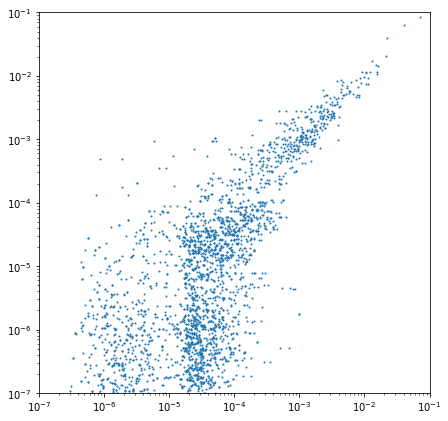

In [135]:
plt.figure(figsize=(7, 7))
plt.scatter(flows_comparison.loc[:, 'v_ij_gt'], flows_comparison.loc[:, 'v_ij'], s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.0000001, 0.1)
plt.ylim(0.0000001, 0.1)

In [136]:
flows_comparison.loc[:, 'v_ij_min'] = flows_comparison.apply(lambda row: min(row['v_ij_gt'], row['v_ij']), axis=1)
SSI = 2 * flows_comparison.loc[:, 'v_ij_min'].sum() / \
      (flows_comparison.loc[:, 'v_ij_gt'].sum() + flows_comparison.loc[:, 'v_ij'].sum())
SSI

0.7943198665531686

## 5. Test model.py that implements the above exploration
The below can be run directly skipping previous cells.

In [14]:
import lib.model as model
import geopandas as gpd
import pandas as pd

grid_file = 'D:/FlowsGeneration/results/grids_sweden/grids_1km_density_deso_with_10km_upper_grids.shp'
grid_file_big = 'D:/FlowsGeneration/results/grids_sweden/grids_10km.shp'
zone_file = 'D:/FlowsGeneration/dbs/sweden/zones/DeSO/DeSO_2018_v2.shp'

In [5]:
grids = gpd.read_file(grid_file)
grids_upper = gpd.read_file(grid_file_big)

In [10]:
df_odm = model.odm(grids=grids, grids_upper=grids_upper, grid_size=(1, 10))
df_odm.head()

  0%|          | 0/5009 [00:00<?, ?it/s]

Generating flows within upper zones...


100%|██████████| 5009/5009 [01:48<00:00, 46.33it/s]


Generating flows between upper zones...
Set diagonal to zero.


,ozone,dzone,d_ij,D_ij_data,D_ij_sim,v_ij,grid_type
0,18,18,0.000000,0.000000,0.000000,0.000000,1
1,18,8,2.236068,1.639817,1.457747,43.436840,1
2,18,20,2.000000,1.648406,1.484936,54.296050,1
3,18,19,1.000000,1.960368,1.740077,217.184198,1
4,18,1,4.472136,1.534267,1.338410,10.859210,1


In [11]:
df_odm.to_csv('dbs/flows_1km_10km_sweden.csv.gz', compression='gzip', index=False)

### Note: D_ij_gt
D_ij_gt is the weighted mean travel distance from the travel survey representing the average travel distance for all the trips generated
between certain deso zones. See the new `lib/sweden.py` for more information.

In [17]:
model_evaluation = model.ModelEvaluation()
model_evaluation.load_gt()
model_evaluation.gt.odm.head()

,ozone,dzone,v_ij_gt,D_ij_gt
0,0114A0010,0114C1170,182551.736842,9.0
1,0114A0010,0163C1140,810292.236111,15.0
2,0114A0010,0163C1170,182927.555556,10.0
3,0114A0010,0163C1350,94404.100629,9.0
4,0114A0010,0163C1380,23397.135431,20.0


Check SSI vs. aggregation level

In [18]:
model_performance = []
for lv in range(2, 8):
    df_odm_agg = model.odm_aggregation(df_odm=df_odm, grids=grids, grids_upper=grids_upper, grid_size=(1, 10), agg_level=lv)
    model_evaluation.gt_aggregation(agg_level=lv)
    ssi = model_evaluation.comparison_ssi(df_odm_agg=df_odm_agg)
    model_performance.append((lv, ssi))

In [19]:
df_performance = pd.DataFrame(model_performance, columns=['agg_level', 'SSI'])
df_performance

,agg_level,SSI
0,2,0.834008
1,3,0.742368
2,4,0.755809
3,5,0.600663
4,6,0.569411
5,7,0.491007
